THE TASK:

1. calculate the topic model for 5 topics based on daln.csv data.
2. train the Naive Bayes classifier (choose the best one) based on rus_doc_short_1.csv data 
3. Select the top 20 documents (with the highest probability) in each topic 
4. calculate the average sentiment score for each topic (based on top 20 document) and build a histogram of the results. 
5. Identify the topic with the most positive and most negative sentiment score

In [2]:
import warnings
warnings.filterwarnings('ignore') 

#importing the data
import pandas as pd
import numpy as np
daln_df = pd.read_csv('daln.csv', encoding='utf-8', sep='delimiter', engine = 'python')

#reading the column with text only
daln_df0 = daln_df.rename(columns={daln_df.columns[0]: "text_original"})
daln_df0.head()

,text_original
0,Лидер движения За права человека Лев Пономар...
1,Здесь в нескольких километрах от города-сателл...
2,По результатам проверок будут приняты «объекти...
3,Посмотрите фотографию. Это нижегородец Никол...
4,8 апреля русская православная церковь праздну...


In [12]:
daln_df0.shape #the data consists of 369 rows of text

(369, 2)

In [6]:
# cleaning and lemmatizing the data with pymorphy
import pymorphy2
from nltk.tokenize import word_tokenize
morph = pymorphy2.MorphAnalyzer()
import re

def clear_data(df):
    df['lem_data'] = df['text_original'].apply(lambda text: text.strip().split('|')[-1].split('http')[0].strip().lower())
    df['lem_data'] = df['text_original'].apply(lambda text: re.sub('[,.\?!:)(«»@#$_1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*`]', '', text))
    return df


def tokenize_and_stem(df):
    df['lem_data'] = df['text_original'].apply(lambda text: word_tokenize(text))
    df['lem_data'] = df['text_original'].apply(lambda text: [morph.parse(word)[0].normal_form for word in text])
    df['lem_data'] = df['text_original'].apply(lambda text: ''.join(text))
    return df


df = clear_data(daln_df0)
df = tokenize_and_stem(df)

df.head()

time of execution (sec) 1623.7168946266174


,text_original,lem_data
0,Лидер движения За права человека Лев Пономар...,Лидер движения За права человека Лев Пономар...
1,Здесь в нескольких километрах от города-сателл...,Здесь в нескольких километрах от города-сателл...
2,По результатам проверок будут приняты «объекти...,По результатам проверок будут приняты «объекти...
3,Посмотрите фотографию. Это нижегородец Никол...,Посмотрите фотографию. Это нижегородец Никол...
4,8 апреля русская православная церковь праздну...,8 апреля русская православная церковь праздну...


In [8]:
print(df['lem_data'][0]) #example of the cleaned and lemmatized data

Лидер движения  За права человека  Лев Пономарев крайне продуктивно встретился с представителем Японского посольства - попросил денег за защиту японских интересов на Дальнем Востоке, предложил свои услуги в борьбе Японии за российские Курилы, и даже похвастался финансирование от Госдепа (привет, скептики!).  Я в свое время высказывался публично, что два: Шикотан и, как его, Хабомаи - я считал, что мы должны отдать, - сказал правозащитник. - Я считаю, что, если бы Россия сделала бы этот шаг, вот с Хабомаи, это было бы правильно  .  Японцы должны быть заинтересованы именно в гражданском обществе там, на Дальнем Востоке, потому что они (местные российские правозащитники) не будут ангажированы на вот этот гнилой такой патриотизм...Понимаете? То есть там разумные люди. И вот вы... Даже решение проблемы островов будет разумным. Агитировать там, обсуждать можно  .Гнилой патриотизм, вот как называет правозащитник отстаивание Россией своих суверенных территорий.   Только надо, чтобы грант давал

In [9]:
file_name='my_stop.txt'
words = pd.read_csv(file_name)

my_stop = words['Stop_words'].values.tolist()
print('the list of stop words: ', my_stop)

#transforming documents into a matrix based on a list of stop-stop words
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(ngram_range=(1,1),stop_words=(my_stop))

the list of stop words:  ['rt', 'ад', 'ан', 'аш', 'бы', 'во', 'вы', 'до', 'др', 'ее', 'ес', 'же', 'за', 'из', 'ик', 'их', 'км', 'ли', 'мм', 'мы', 'на', 'не', 'ни', 'но', 'об', 'он', 'ос', 'от', 'по', 'рф', 'см', 'со', 'ст', 'то', 'ты', 'ум', 'щи', 'эз', 'эн', 'юг', 'яд', 'and', 'абс', 'абу', 'акт', 'аль', 'без', 'бин', 'или', 'она']


In [10]:
#transforming texts into the matrix of frequencies
x = vec.fit_transform(df['lem_data'])
data = vec.fit_transform(df['lem_data']).toarray()

num_docs, num_feature =x.shape #the number of features and rows in the dataset
print('doc number: ', num_docs)
print('features number: ', num_feature)

#getting a list of features (words)
tf_feature_names = vec.get_feature_names()

doc number:  369
feature number:  61835


In [13]:
# import model for LDA
from sklearn.decomposition import LatentDirichletAllocation
#defining parameters for the model
lda_model = LatentDirichletAllocation(n_components = 5,  # topics number.
                                      max_iter=100,               # number of itteration
                                      learning_method='online',  # Online variational Bayes method 
                                      random_state=100,          # random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # use all available CPUs
                                     )

# run model
lda_output = lda_model.fit_transform(data)

print(lda_model)  # Model attributes

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_hand

done in :  985.00075507164


In [18]:
#now I need to get top-20 documents for each topic assigned in a separated dataframe
#for that I will do the following steps

topicnames = ["Topic" + str(i) for i in range(5)]
docnames = ['Doc' + str(i) for i in range(len(data))]

# creating a dataframe with the distribution of topics in documents
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

def doc_extr(dataset, topic_num, n):
    """
        dataset - dataset with docs in topic distribution
        topic_num - topic numeber (name)
    """
    sorted_data = dataset.sort_values(topic_num)
    # select the column that was sorted above
    myresult = sorted_data[topic_num]

    # getting a list of documents in the specified topic
    result = myresult[-(n-1):].index
    return result

In [90]:
# specifying the number of documents for each topic
alpha = 21

topic0_docs = doc_extr(df_document_topic, 'Topic0', alpha)
topic1_docs = doc_extr(df_document_topic, 'Topic1', alpha)
topic2_docs = doc_extr(df_document_topic, 'Topic2', alpha)
topic3_docs = doc_extr(df_document_topic, 'Topic3', alpha)
topic4_docs = doc_extr(df_document_topic, 'Topic4', alpha)

# print out a indexes of documents
print(topic0_docs)
print(topic1_docs)
print(topic2_docs)
print(topic3_docs)
print(topic4_docs)

Index(['Doc100', 'Doc233', 'Doc283', 'Doc280', 'Doc160', 'Doc158', 'Doc147',
       'Doc145', 'Doc266', 'Doc66', 'Doc127', 'Doc75', 'Doc186', 'Doc36',
       'Doc245', 'Doc105', 'Doc103', 'Doc222', 'Doc162', 'Doc255'],
      dtype='object')
Index(['Doc12', 'Doc223', 'Doc50', 'Doc85', 'Doc287', 'Doc238', 'Doc82',
       'Doc244', 'Doc115', 'Doc3', 'Doc47', 'Doc188', 'Doc121', 'Doc64',
       'Doc94', 'Doc98', 'Doc179', 'Doc59', 'Doc39', 'Doc62'],
      dtype='object')
Index(['Doc176', 'Doc337', 'Doc76', 'Doc124', 'Doc296', 'Doc119', 'Doc93',
       'Doc54', 'Doc329', 'Doc12', 'Doc357', 'Doc85', 'Doc287', 'Doc223',
       'Doc238', 'Doc244', 'Doc82', 'Doc115', 'Doc50', 'Doc236'],
      dtype='object')
Index(['Doc163', 'Doc337', 'Doc76', 'Doc119', 'Doc329', 'Doc93', 'Doc176',
       'Doc296', 'Doc50', 'Doc12', 'Doc357', 'Doc85', 'Doc223', 'Doc287',
       'Doc244', 'Doc82', 'Doc238', 'Doc115', 'Doc45', 'Doc345'],
      dtype='object')
Index(['Doc119', 'Doc337', 'Doc76', 'Doc176', 'Doc296'

In [94]:
#creating lists with top-20 documents for each topic

topic0_text = []
topic1_text = []
topic2_text = []
topic3_text = []
topic4_text = []

for i in range(len(df['lem_data'])):
    for j in topic0_docs:
        tt = j.replace('Doc','')
        ttnum = int(tt)
        if ttnum==i: topic0_text.append(df['lem_data'][i])
            
for i in range(len(df['lem_data'])):
    for j in topic1_docs:
        tt = j.replace('Doc','')
        ttnum = int(tt)
        if ttnum==i: topic1_text.append(df['lem_data'][i])
            
            
for i in range(len(df['lem_data'])):
    for j in topic2_docs:
        tt = j.replace('Doc','')
        ttnum = int(tt)
        if ttnum==i: topic2_text.append(df['lem_data'][i])
            
            
for i in range(len(df['lem_data'])):
    for j in topic3_docs:
        tt = j.replace('Doc','')
        ttnum = int(tt)
        if ttnum==i: topic3_text.append(df['lem_data'][i])     
            

for i in range(len(df['lem_data'])):
    for j in topic4_docs:
        tt = j.replace('Doc','')
        ttnum = int(tt)
        if ttnum==i: topic4_text.append(df['lem_data'][i])
    
print('number of documents, Topic0: ', len(topic0_text))
print('number of documents, Topic1: ', len(topic1_text))
print('number of documents, Topic2: ', len(topic2_text))
print('number of documents, Topic3: ', len(topic3_text))
print('number of documents, Topic4: ', len(topic4_text))

number of documents, Topic0:  20
number of documents, Topic1:  20
number of documents, Topic2:  20
number of documents, Topic3:  20
number of documents, Topic4:  20


## Bayes classifier

Now, I am going to train Bayes classifier on another dataset

In [3]:
bayes_data = pd.read_csv('rus_doc_short_1.csv', delimiter=';', encoding='ANSI')
print('Dataset size', bayes_data.shape)
bayes_data.head()

Dataset size (1001, 2)


,original_dosc,score
0,ет. Нам не нужны Мухин и Бинх в качестве начал...,-1
1,ровой сильный кандидат и достойный противник. ...,0
2,гомоцистеином по-видимому довольно просто экс...,-1
3,о турки беспрепятственно разврешают американск...,0
4,У меня нет достаточной информации чтобы сдела...,0


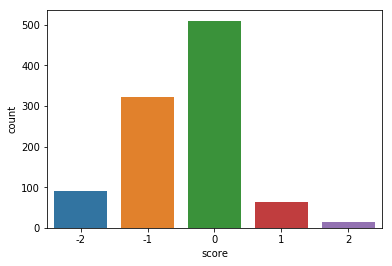

In [5]:
#the data contains text sentiment scores which have 5 levels
#as I guess '-2' and '-1' can be defined as 'negative' ones and '1' and '2' as 'positive' ones
import seaborn as sns
sns.countplot(x = 'score', data = bayes_data) 

In [29]:
#cleaning and stemming the data with SnowballStemmer

from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def clear_dataN(df):
    df['text'] = df['original_dosc'].apply(lambda text: text.strip().split('|')[-1].split('http')[0].strip().lower())
    df['text'] = df['text'].apply(lambda text: re.sub('[?!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*``,.]', '', text))
    return df
    

def tokenize_and_stemS(df):
    df['text'] = df['original_dosc'].apply(lambda text: word_tokenize(text))
    df['text'] = df['text'].apply(lambda text: [stemmer.stem(word) for word in text])
    df['text'] = df['text'].apply(lambda text: ' '.join(text))
    return df

#preprocessing
bayes_df = clear_dataN(bayes_data)
bayes_df = tokenize_and_stemS(bayes_df)

bayes_df.head()

,original_dosc,score,text
0,ет. Нам не нужны Мухин и Бинх в качестве начал...,-1,ет . нам не нужны мухин и бинх в качестве нача...
1,ровой сильный кандидат и достойный противник. ...,0,ровой сильный кандидат и достойный противник ....
2,гомоцистеином по-видимому довольно просто экс...,-1,гомоцистеином по-видимому довольно просто эксп...
3,о турки беспрепятственно разврешают американск...,0,о турки беспрепятственно разврешают американск...
4,У меня нет достаточной информации чтобы сдела...,0,у меня нет достаточной информации чтобы сделат...


In [30]:
data_classify = vec.fit_transform(bayes_df['text']).toarray()

num_docs, num_feature = data_classify.shape
print('number of docs: ', num_docs, ' number features: ', num_feature)

number of docs:  1001  number features:  35054


In [34]:
#fter the data for training is preprocessed, the training of the classifier can be done
myfich = vec.get_feature_names()

X = data_classify
Y = bayes_df['score'].values

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('Test collection size: ', X_test.shape)
print('Training collection size: ', X_train.shape)

Test collection size:  (201, 35054)
Training collection size:  (800, 35054)


In [40]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB


# there are three options for Bayes predictive modeling
#I will try all three to determine which of them performs better in terms of F1 score
bayes1 = GaussianNB()
bayes2 = MultinomialNB()
bayes3 = BernoulliNB()

bayes1.fit(X_train, y_train)
bayes2.fit(X_train, y_train)
bayes3.fit(X_train, y_train)


scores1 = cross_val_score(bayes1, X_train, y_train, cv=5, scoring='f1_macro')
print('Mean value of f1_macro among the folds for GaussianNB: ', np.mean(scores1))

scores2 = cross_val_score(bayes2, X_train, y_train, cv=5, scoring='f1_macro')
print('Mean value of f1_macro among the folds for MultinomialNB: ', np.mean(scores2))

scores3 = cross_val_score(bayes3, X_train, y_train, cv=5, scoring='f1_macro')
print('Mean value of f1_macro among the folds for BernoulliNB: ', np.mean(scores3))

Mean value of f1_macro among the folds for GaussianNB:  0.2108484251734794
Mean value of f1_macro among the folds for MultinomialNB:  0.14060789916509886
Mean value of f1_macro among the folds for BernoulliNB:  0.13904823597091057


Looks like GaussianNB is the best one.

Now the chosen model can be tested on the daln texts

In [114]:
topic0 = vec.transform(topic0_text).toarray()
topic1 = vec.transform(topic1_text).toarray()
topic2 = vec.transform(topic2_text).toarray()
topic3 = vec.transform(topic3_text).toarray()
topic4 = vec.transform(topic4_text).toarray()

num_docs, num_feature = topic0.shape
print('documents number : ', num_docs, 'feature number: ', num_feature)

documents number :  20 feature number:  35054


Below are the predicted sentiment scores distribution for each topic. This way it can be determined which topic is the most 'negative' and most 'positive' ones.

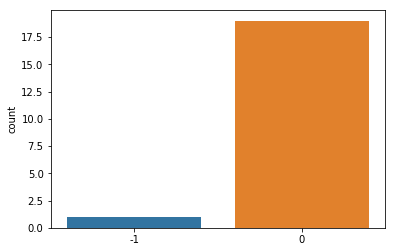

In [116]:
topic0_predicted = bayes1.predict(topic0)

import seaborn as sns 
sns.countplot(topic0_predicted) #1 doc with negative score, 19 docs with neutral scores

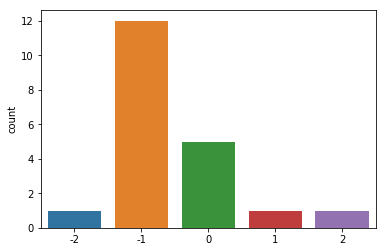

In [117]:
topic1_predicted = bayes1.predict(topic1)

sns.countplot(topic1_predicted) #12 docs with negative scores
#2 docs with positive scores

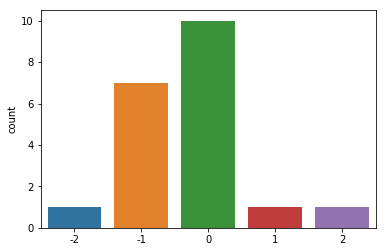

In [119]:
topic2_predicted = bayes1.predict(topic2)

sns.countplot(topic2_predicted) #8 docs with negative scores
#2 docs with positive scores

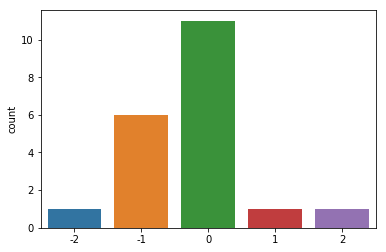

In [120]:
topic3_predicted = bayes1.predict(topic3)

sns.countplot(topic3_predicted) #7 docs w/negative scores
#2 docs with positive scores

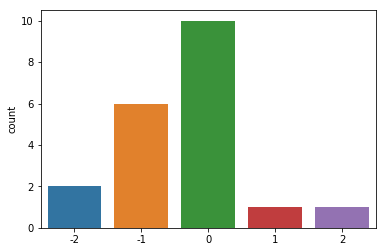

In [121]:
topic4_predicted = bayes1.predict(topic4)

sns.countplot(topic4_predicted) #9 docs with negative scores
#2 docs with positive scores

Looks like Topic0 is the most "positive" one, or either neutral as there are no topics distinguished by their 'positivity' - all of them have too few texts with positive sentiment. And Topic1 is the most "negative", for sure.